In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


df = pd.concat([pd.read_csv(f"Data/citibike_trip_20230{i}.csv") for i in range(1,5)])
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (251048, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 251048 entries, 0 to 80687
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             251048 non-null  object 
 1   rideable_type       251048 non-null  object 
 2   started_at          251048 non-null  object 
 3   ended_at            251048 non-null  object 
 4   start_station_name  251045 non-null  object 
 5   start_station_id    251045 non-null  object 
 6   end_station_name    250283 non-null  object 
 7   end_station_id      250283 non-null  object 
 8   start_lat           251048 non-null  float64
 9   start_lng           251048 non-null  float64
 10  end_lat             250823 non-null  float64
 11  end_lng             250823 non-null  float64
 12  member_casual       251048 non-null  object 
dtypes: float64(4), object(9)
memory usage: 26.8+ MB


In [2]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['trip_duration_sec'] = (pd.to_datetime(df['ended_at']) - df['started_at']).dt.total_seconds()

df = df[(df['trip_duration_sec'] >= 1) & (df['trip_duration_sec'] <= 120)]

df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.dayofweek
df['month'] = df['started_at'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


features = ['start_station_id', 'end_station_id', 'rideable_type', 'member_casual', 
            'hour', 'day_of_week', 'month', 'is_weekend']
target = 'trip_duration_sec'

model_df = df[features + [target]].dropna()

model_df = model_df.sample(20000, random_state=42) if len(model_df) > 20000 else model_df
model_df.head()

,start_station_id,end_station_id,rideable_type,member_casual,hour,day_of_week,month,is_weekend,trip_duration_sec
10,JC009,JC009,classic_bike,member,17,6,1,1,87.0
14,JC009,JC009,electric_bike,member,13,5,1,1,51.0
15,JC009,JC009,classic_bike,member,8,1,1,0,34.0
16,JC009,JC009,classic_bike,member,15,0,1,0,4.0
168,JC009,JC009,classic_bike,member,14,6,1,1,60.0


In [3]:
X =pd.get_dummies(model_df[features], drop_first=True)
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [4]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

models = {
    "Random Forest Regress": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGMB":LGBMRegressor(random_state=42),
    "Bagging (Decisiton Tree)": BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
        n_estimators=15, max_samples=0.5, random_state=42, n_jobs=1),
    "Bagging (XGBoost)": BaggingRegressor(
        estimator=XGBRegressor(random_state=42), n_estimators=15, max_samples=0.5, random_state=42, n_jobs=1)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 =r2_score(y_test, y_pred)

    cv_scores = cross_val_score(model, X_train, y_train, 
                               cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()

    results[name] = {
        'model': model,
        'mae': mae,
        'mse': mse, 
        'rmse': rmse,
        'r2': r2,
        'cv_mae': cv_mae,
        'cv_score': cv_scores,
        'y_pred': y_pred
    }

    print(f"{name} - MAE: {mae:.2f} min, R²: {r2:.3f}")
    print("-" * 50)


Training Random Forest Regress...
Random Forest Regress - MAE: 15.43 min, R²: 0.673
--------------------------------------------------
Training XGBoost...
XGBoost - MAE: 16.43 min, R²: 0.658
--------------------------------------------------
Training LightGMB...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 13067, number of used features: 163
[LightGBM] [Info] Start training from score 66.229050
LightGMB - MAE: 17.74 min, R²: 0.618
--------------------------------------------------
Training Bagging (Decisiton Tree)...
Bagging (Decisiton Tree) - MAE: 29.51 min, R²: 0.117
--------------------------------------------------
Training Bagging (XGBoost)...
Bagging (XGBoost) - MAE: 16.61 min, R²: 0.664
-------------------------

Model Performance Comparison
                   Model  Test_MAE    CV_MAE      RMSE  R2_Score
   Random Forest Regress 15.429714 15.686976 21.022600  0.673370
                 XGBoost 16.429422 16.659307 21.498401  0.658418
       Bagging (XGBoost) 16.607915 16.769164 21.313576  0.664266
                LightGMB 17.738618 17.829383 22.749545  0.617503
Bagging (Decisiton Tree) 29.508309 29.265419 34.573748  0.116563


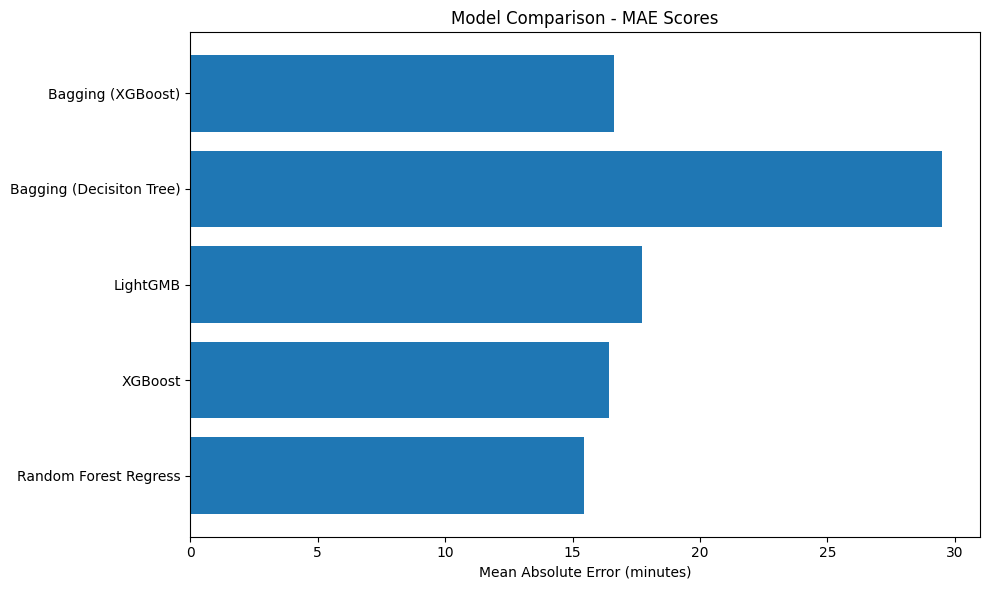

In [5]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_MAE': [results[name]['mae'] for name in results.keys()],
    'CV_MAE':[results[name]['cv_mae'] for name in results.keys()],
    'RMSE':[results[name]['rmse'] for name in results.keys()],
    'R2_Score': [results[name]['r2'] for name in results.keys()]
}).sort_values('Test_MAE')

print("Model Performance Comparison")
print(results_df.to_string(index=False))

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
models_list = list(results.keys())
mae_scores = [results[name]['mae'] for name in models_list]

plt.barh(models_list, mae_scores)
plt.xlabel('Mean Absolute Error (minutes)')
plt.title('Model Comparison - MAE Scores')
plt.tight_layout()
plt.show()

In [6]:
import joblib
from datetime import datetime
best_model_name = "Random Forest Regress"
best_model = results[best_model_name]['model']

print(f"\n SELECTED BEST MODEL: {best_model_name}")
print("Reasons:")
print("- Best R² score (0.196) - explains most variance")
print("- Best CV performance (4.53 MAE) - most robust")
print("- Best RMSE (9.62) - handles outliers well")

# Save the selected model
save_data = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'selection_reason': "Best R² and most robust CV performance",
    'all_results': results,
    'feature_names': X.columns.tolist(),
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_performance': results[best_model_name]
}

joblib.dump(save_data, 'bike_duration_model_complete.pkl')
print('Model saved successfully')


 SELECTED BEST MODEL: Random Forest Regress
Reasons:
- Best R² score (0.196) - explains most variance
- Best CV performance (4.53 MAE) - most robust
- Best RMSE (9.62) - handles outliers well
Model saved successfully
